In [4]:
%pylab
%matplotlib inline
from numba import jit, njit, cfunc

Using matplotlib backend: Qt5Agg
Populating the interactive namespace from numpy and matplotlib


The best units for this type of problem are the total mass, the orbital separation, and the dynamical time. In these units G=1.

In [97]:
#Rjup = 5.345
q = 9.5458e-4 # jupiter-sun mass ratio
#mega = 0.5083
#Gmsun = 39.42
#Gmjup = q * Gmsun

@njit
def ThreeBodyDeriv(y, t):
    q = 9.5458e-4
    m1 = 1/(1+q)
    m2 = q/(1+q)
    
    pos = y[:2]
    v = y[2:]
        
    # coordinates of the gravitating bodies in the corotating frame
    x2 = m1/(m1+m2)
    y2 = 0
    x1 = -m2/(m1+m2)
    y1 = 0
    
    # we'll store GMi/Ri^3 for efficient reuse
    fac1 = np.sqrt((pos[0]-x1)*(pos[0]-x1) +  (pos[1]-y1)*(pos[1]-y1))
    fac1 = m1/(fac1*fac1*fac1)
    
    fac2 = np.sqrt((pos[0]-x2)*(pos[0]-x2) +  (pos[1]-y2)*(pos[1]-y2))
    fac2 = m2/(fac2*fac2*fac2)
    
    # gravitational acceleration
    ax = (x1 - pos[0]) * fac1 + (x2 - pos[0]) * fac2
    ay = (y1 - pos[1]) * fac1 + (y2 - pos[1]) * fac2
    
    # Coriolis 
    ax += -2 * (-v[1])
    ay += -2 * v[0]
    
    # Centrifugal
    ax += pos[0]
    ay += pos[1]
    
    return np.array([y[2],y[3], ax, ay])

In [98]:
@jit
def RK4(deriv, y0, h, T):
    Nsteps = int(T/h + 0.5)
    y = np.empty((Nsteps+1, len(y0)))
    y[0] = y0
    t = np.linspace(0, Nsteps*h, Nsteps + 1)
    for i in range(Nsteps):
        k1 = h * deriv(y[i], t[i]) # euler step
        k2 = h * deriv(y[i] + 0.5*k1, t[i] + 0.5*h) # midpoint step
        k3 = h * deriv(y[i] + 0.5*k2, t[i] + 0.5*h) # refined midpoint step
        k4 = h * deriv(y[i] + k3, t[i] + h) # whole step using the refined midpoint step
        y[i+1] = y[i] + k1/6 + k2/3 + k3/3 + k4/6
    return t, y
    

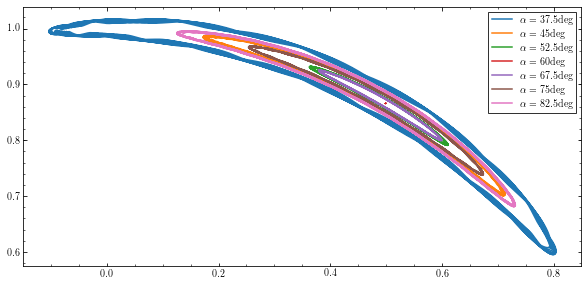

In [115]:
m1 = 1/(1+q)
m2 = q/(1+q)
R = (m1-m2)

alphas = np.pi/3 + np.pi/24 * np.arange(-3,4) # 15deg increments

plt.figure(figsize=(10,10))

for alpha in alphas:

    y0 = np.array([R*np.cos(alpha),np.sin(alpha) + np.random.normal()*1e-5, 0.,0.])

    Tmax = 2*np.pi*100
    t, y = RK4(ThreeBodyDeriv, y0, 0.1, Tmax)

    plt.plot(y[:,0], y[:,1], label=r"$\alpha=%g{\rm deg}$"%(alpha*180/np.pi))
#plt.xlim(-1.1,1.1)
#plt.ylim(-1.1,1.1)
#plt.scatter([1/(1+q),-q/(1+q)], [0,0])
plt.legend()
plt.axes().set_aspect('equal')
plt.show()

In [96]:
%timeit RK4(ThreeBodyDeriv, y0, 0.01, Tmax)

1 loop, best of 3: 1.47 s per loop


In [48]:
@cfunc("float64[:](float64[:], float64)")
def deriv2(y, t):
    return -np.array([y[1],-y[0]])

In [51]:
deriv2.ctypes(np.array([0.,1.]).ctypes, 0.)

TypeError: Cannot convert Numba type 'array(float64, 1d, A)' to ctypes type

In [53]:
import ctypes
ctypes.pointer(np.array([1.,0.]))

TypeError: _type_ must have storage info